# Resolvendo problema microchip via redes neurais


In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import relu,linear
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

import matplotlib as mpl

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

tf.keras.backend.set_floatx('float64')

tf.autograph.set_verbosity(0)
dlc = dict(dlblue = '#0096ff', dlorange = '#FF9300', dldarkred='#C00000', dlmagenta='#FF40FF', dlpurple='#7030A0', dldarkblue =  '#0D5BDC')
dlblue = '#0096ff'; dlorange = '#FF9300'; dldarkred='#C00000'; dlmagenta='#FF40FF'; dlpurple='#7030A0'; dldarkblue =  '#0D5BDC'
dlcolors = [dlblue, dlorange, dldarkred, dlmagenta, dlpurple]

dkcolors = plt.cm.Paired((1,3,7,9,5,11))
ltcolors = plt.cm.Paired((0,2,6,8,4,10))
dkcolors_map = mpl.colors.ListedColormap(dkcolors)
ltcolors_map = mpl.colors.ListedColormap(ltcolors)

def plt_mc_data(ax, X, y, classes,  class_labels=None, map=plt.cm.Paired, legend=False,size=50, m='o'):
    for i in range(classes):
        idx = np.where(y == i)
        col = len(idx[0])*[i]
        label = class_labels[i] if class_labels else "c{}".format(i)
        ax.scatter(X[idx, 0], X[idx, 1],  marker=m,
                    c=col, vmin=0, vmax=map.N, cmap=map,
                    s=size, label=label)
    if legend: ax.legend()
    ax.axis('equal')


# Plota fronteira de decisão para múltiplas classes
# Essa versão lida com uma previsão não-vetorizada (adiciona um loop for sobre os pontos)
def plot_cat_decision_boundary(ax, X,predict , class_labels=None, legend=False, vector=True, color='g', lw = 1):

    # Cria grade de pontos
    pad = 0.5
    x_min, x_max = X[:, 0].min() - pad, X[:, 0].max() + pad
    y_min, y_max = X[:, 1].min() - pad, X[:, 1].max() + pad
    h = max(x_max-x_min, y_max-y_min)/200
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    points = np.c_[xx.ravel(), yy.ravel()]

    #faz previsão para cada ponto
    if vector:
        Z = predict(points)
    else:
        Z = np.zeros((len(points),))
        for i in range(len(points)):
            Z[i] = predict(points[i].reshape(1,2))
    Z = Z.reshape(xx.shape)

    # Plot de contorno destaca as fronteiras entre os valores - classes nesse caso
    ax.contour(xx, yy, Z, colors=color, linewidths=lw)
    ax.axis('tight')

def recat(pt, origins):
    """ Classifica um ponto com base na distância dos clusters de origem """
    nclusters = len(origins)
    min_dist = 10000
    y_new = None
    for j in range(nclusters):
        temp = origins[j] - pt.reshape(2,)
        #print(temp.shape,origins[j].shape)
        dist = np.sqrt(np.dot(temp.T, temp))
        if dist < min_dist:
            y_new = j
            min_dist = dist
    return(y_new)

def plt_train_eq_dist(X_train,y_train,classes, X_cv,   y_cv, centers, std):
    css = np.unique(y_train)
    fig,ax = plt.subplots(1,2,figsize=(8,4))
    fig.canvas.toolbar_visible = False
    fig.canvas.header_visible = False
    fig.canvas.footer_visible = False
    plt_mc_data(ax[0], X_train,y_train,classes, map=dkcolors_map, legend=True, size=50)
    plt_mc_data(ax[0], X_cv,   y_cv,   classes, map=ltcolors_map, legend=True, m="<")
    ax[0].set_title("Dados treinamento, Dados CV")
    for c in css:
        circ = plt.Circle(centers[c], 2*std, color=dkcolors_map(c), clip_on=False, fill=False, lw=0.5)
        ax[0].add_patch(circ)


    # construindo modelo para rotinas de plot
    cat_predict = lambda pt: recat(pt.reshape(1,2), centers)
    plot_cat_decision_boundary(ax[1], X_train, cat_predict,  vector=False, color = dlc["dlmagenta"], lw=0.75)
    ax[1].set_title("performance ideal", fontsize=14)

    # Adiciona os dados originais à fronteira de decisão
    plt_mc_data(ax[1], X_train,y_train, classes, map=dkcolors_map, legend=True, size=50)
    ax[1].set_xlabel('x0') ; ax[1].set_ylabel("x1");
    plt.show()


def plt_nn(model_predict,X_train,y_train, classes, X_cv, y_cv, suptitle=""):
    # Plota a fronteira de decisão
    fig,ax = plt.subplots(1,2, figsize=(8,4))
    fig.canvas.toolbar_visible = False
    fig.canvas.header_visible = False
    fig.canvas.footer_visible = False
    plot_cat_decision_boundary(ax[0], X_train, model_predict,  vector=True)
    ax[0].set_title("dados treinamento", fontsize=14)

    # Adiciona os dados originais à fronteira de decisão
    plt_mc_data(ax[0], X_train,y_train, classes, map=dkcolors_map, legend=True, size=75)
    ax[0].set_xlabel('x0') ; ax[0].set_ylabel("x1");

    plot_cat_decision_boundary(ax[1], X_train, model_predict,  vector=True)
    ax[1].set_title("dados validação cruzada", fontsize=14)
    plt_mc_data(ax[1], X_cv,y_cv, classes,
                map=ltcolors_map, legend=True, size=100, m='<')
    ax[1].set_xlabel('x0') ; ax[1].set_ylabel("x1");
    fig.suptitle(suptitle,fontsize = 12)
    plt.show()


2024-11-29 15:22:58.053851: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-29 15:22:58.328710: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Carregando os dados:

In [2]:
file = open('dados_microchip.txt') # As duas primeiras colunas referem-se às características -> resultados obtidos pelos microchips nos teste 1 e 2
                                   # A terceira (última) coluna refere-se ao resultado do teste de GQ (1 significa chip aprovado)
dados = np.loadtxt(file, delimiter=",")

X = dados[:,0:2]
y = dados[:,-1] # pega apenas a última coluna.

Vizualizando numericamente os dados:

In [3]:
# print X_train
print("X:", X[:5])
print("Tipo do X:",type(X))

# print y_train
print("y:", y[:5])
print("Tipo do y:",type(y))

X: [[ 0.051267  0.69956 ]
 [-0.092742  0.68494 ]
 [-0.21371   0.69225 ]
 [-0.375     0.50219 ]
 [-0.51325   0.46564 ]]
Tipo do X: <class 'numpy.ndarray'>
y: [1. 1. 1. 1. 1.]
Tipo do y: <class 'numpy.ndarray'>


#### Cheque as dimensões das suas variáveis


Uma outra forma útil para se familizarizar com os dados é visualizar suas dimensões.
Vamos dar print dos shapes de `X` e `y`para verificar quantas amostras nós temos no nosso conjunto de dados.


In [4]:
print ('O shape de X é: ' + str(X.shape))
print ('O shape de y é: ' + str(y.shape))
print ('Nós temos %d exemplos (amostras)' % (len(y)))

O shape de X é: (118, 2)
O shape de y é: (118,)
Nós temos 118 exemplos (amostras)


Plotando os dados:

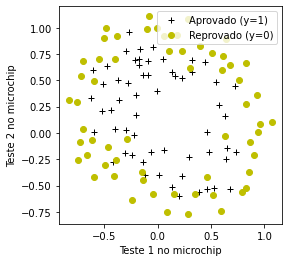

In [5]:
pos = y == 1 # identifica os elementos em y que são iguais a 1
neg = y == 0 # identifica os elementos em y que são iguais a 0

fig,ax = plt.subplots(1,1,figsize=(4,4))
ax.plot(X[pos,0], X[pos,1], 'k+', label="Aprovado (y=1)")
ax.plot(X[neg,0], X[neg,1], 'yo', label="Reprovado (y=0)")

#ax.axis([0, 4, 0, 3.5])
ax.set_ylabel('Teste 2 no microchip')
ax.set_xlabel('Teste 1 no microchip')
ax.legend()
plt.show()

A figura acima mostra que nosso conjunto de dados não pode ser separado em amostras positivas e negativas usando uma reta. Logo, uma aplicação direta da Regressão Logística não irá performar bem nesse conjunto de dados uma vez que a Regressão Logística não conseguirá encontrar uma Fronteira de Decisão linear adequada.

Por outro lado, sabemos que redes neurais são capazes de criar características complexas naturalmente, por vezes prescindindo da necessidade de realização de uma engenharia de características.

Abaixo nós dividimos os dados entre dados de treinamento e dados de teste:

In [6]:
from sklearn.model_selection import train_test_split

# Dividindo os dados.
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.30, random_state=1)

print(y_train.shape, y_test.shape)

(82,) (36,)


### Mapeamento de características


Não será necessário neste exemplo, pois usaremos redes neurais ao invés de Regressão Logística

## Modelo simples

Abaixo criamos uma rede neural simples para tentar resolver tal problema de classificação.

In [7]:
tf.random.set_seed(1234)
modelo_simples = Sequential(
    [
        # Insira seu código aqui
    ], name = "Modelo_simples"
)
modelo_simples.compile(
    loss=SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(0.01),
)
modelo_simples.fit(
    X_train,y_train,
    epochs=1000
)

Epoch 1/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.7267
Epoch 2/1000
3/3 [==============================] - 0s 1ms/step - loss: 0.7267
Epoch 3/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.7267
Epoch 4/1000
3/3 [==============================] - 0s 1ms/step - loss: 0.7267
Epoch 5/1000
3/3 [==============================] - 0s 891us/step - loss: 0.7267
Epoch 6/1000
3/3 [==============================] - 0s 1ms/step - loss: 0.7267
Epoch 7/1000
3/3 [==============================] - 0s 1ms/step - loss: 0.7267
Epoch 8/1000
3/3 [==============================] - 0s 985us/step - loss: 0.7267
Epoch 9/1000
3/3 [==============================] - 0s 855us/step - loss: 0.7267
Epoch 10/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.7267
Epoch 11/1000
3/3 [==============================] - 0s 1ms/step - loss: 0.7267
Epoch 12/1000
3/3 [==============================] - 0s 871us/step - loss: 0.7267
Epoch 13/1000
3/3 [======================

In [8]:
modelo_simples.summary()

Model: "Modelo_simples"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 0 (0.00 Byte)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


1225/1225 [==============================] - 1s 481us/step


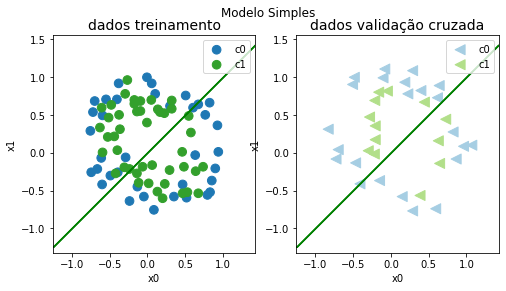

In [9]:

classes = 2 # quantidade de classes

#abaixo criamos um modelo para realizar previsões. Deixamos em aberto quem será a matriz de características de entrada Xl.
modelo_previsao_simples = lambda Xl: np.argmax(tf.nn.softmax(modelo_simples.predict(Xl)).numpy(),axis=1)

plt_nn(modelo_previsao_simples,X_train,y_train, classes, X_test, y_test, suptitle="Modelo Simples")

In [10]:
# Escreva um código capaz de calcular a taxa de acerto para os dados de teste


print(f"taxa de acerto para os dados de teste: {taxa_acerto_test}")


NameError: name 'taxa_acerto_test' is not defined

In [ ]:
import seaborn as sns

def plotando_matriz_de_confusao(y, y_hat, rotulos):
  matriz_confusao = tf.math.confusion_matrix(y, y_hat)
  ax = sns.heatmap(matriz_confusao, annot=True, fmt='g')
  sns.set(rc={'figure.figsize':(12, 12)})
  sns.set(font_scale=1.4)
  ax.set_title('Matriz de confusão')
  ax.set_xlabel('Previsão')
  ax.set_ylabel('Valor verdadeiro')
  plt.xticks(rotation=90)
  plt.yticks(rotation=0)
  ax.xaxis.set_ticklabels(rotulos)
  ax.yaxis.set_ticklabels(rotulos)

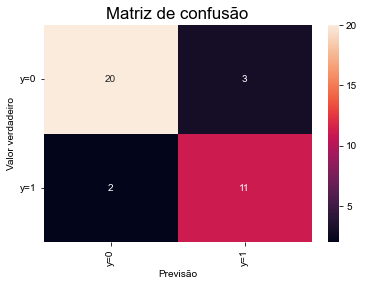

In [ ]:
rotulos = ["y=0","y=1"]

plotando_matriz_de_confusao(y_test, Yhat, rotulos)

In [ ]:
precisao, recall = calculando_metricas_classificacao(y_test, Yhat, rotulos)

print("precisao: ", precisao)

print("recall: ", recall)

precisao:  {'y=0': 0.9090909090909091, 'y=1': 0.7857142857142857}
recall:  {'y=0': 0.8695652173913043, 'y=1': 0.8461538461538461}
